# Lab: using clustering to find best store locations

Imagine the following situation:<br>
You own a pizza chain, and you collected data about pizza deliveries in a certain neighborhood. The data contains a coordinate of each delivery as a pair *(Latitude, Longitude)*. You do not have any stores in this neighborhood, and driving there each time is too expensive (especially with current gas prices). So you decide to open $K$ new stores in this area. The task is, based on the frequent delivery data, determine the best locations for the new stores.

You need to perform the $K$-means clustering of delivery locations, and otput the best location for $K$ new stores. How would you choose the location of the store within each cluster that minimizes the overall distance between the store and each delivery address? __Explain your idea in a separate cell below.__

The idea: the simplest idea is to find out all locations and if they are scattered, try clustering them into K clusters and put the store at the centroid of each clusters. If the clusters are chosen wisely, it should reduce the total distance needed. However, if we consider weight in mind, the customized code may not be adequate. It could possibly be fixed using sklearn.kmeans with weight in clustering. Although the weight are considered when trying to find the best location within the cluster in our custom code, the unweighted cluster may be inadequate. I am showing both custom code and ML kmeans method to find the best store locations, and the graphs should show the difference between the two methods. 

The data is 2-dimensional and it is easy to plot it to see if the locations of new stores make sense.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

The data is a real data collected by [this person](https://github.com/angelddaz) while they were working as a pizza delivery driver. The file [pizza_delivery_locations.csv](https://drive.google.com/file/d/1tSpqC5sM7DegMil4D9U3DN9exYNATpiA/view?usp=sharing) is a projection of the original data and contains only *(Latitude, Longitude)* of each delivery address. Download the file and update the path below.

In [3]:
data_file = "pizza_delivery_locations.csv"

In [4]:

data = pd.read_csv(data_file)
store = data.copy()
unique = data.copy()
unique = unique.drop_duplicates()

print(data.columns)
len(data)

# convert dataframe to a 2D numpy array - it is easier to work with it
unique = unique.to_numpy()
print(unique)
data = data.to_numpy()

Index(['Latitude', 'Longitude'], dtype='object')
[[  43.666573 -116.263356]
 [  43.652722 -116.259743]
 [  43.624462 -116.21835 ]
 [  43.633857 -116.24628 ]
 [  43.672328 -116.286124]
 [  43.633105 -116.208304]
 [  43.723879 -116.255046]
 [  43.648076 -116.23413 ]
 [  43.659428 -116.231891]
 [  43.654203 -116.190788]]


## Task 1.

Use $K$-means clustering algorithm to find the best locations for new pizza stores for $K$=2, $K$=3 and $K$=4. The answers should be represented as lists of *(Latitide,Longitude)* tuples for each value of $K$.

You can use the custom code from the k-means demo, or you can use the `sklearn.KMeans` module to perform clustering.

In [5]:

from math import sqrt

def manhattan(v1,v2):
    res=0
    dimensions=min(len(v1),len(v2))

    for i in range(dimensions):
        res+=abs(v1[i]-v2[i])

    return res


def euclidean(v1,v2):
    res=0
    dimensions=min(len(v1),len(v2))
    for i in range(dimensions):
        res+=pow(abs(v1[i]-v2[i]),2)

    return sqrt(float(res))


def cosine(v1,v2):
    dotproduct=0
    dimensions=min(len(v1),len(v2))

    for i in range(dimensions):
        dotproduct+=v1[i]*v2[i]

    v1len=0
    v2len=0
    for i in range (dimensions):
        v1len+=v1[i]*v1[i]
        v2len+=v2[i]*v2[i]

    v1len=sqrt(v1len)
    v2len=sqrt(v2len)
    
    # we need distance here - 
    # we convert cosine similarity into distance
    return 1.0-(float(dotproduct)/(v1len*v2len))
  

def pearson(v1,v2):
    # Simple sums
    sum1=sum(v1)
    sum2=sum(v2)
  
    # Sums of the squares
    sum1Sq=sum([pow(v,2) for v in v1])
    sum2Sq=sum([pow(v,2) for v in v2])
  
    # Sum of the products
    pSum=sum([v1[i]*v2[i] for i in range(min(len(v1),len(v2)))])
  
    # Calculate r (Pearson score)
    numerator=pSum-(sum1*sum2/len(v1))
    denominator=sqrt((sum1Sq-pow(sum1,2)/len(v1))*(sum2Sq-pow(sum2,2)/len(v1)))
    if denominator==0: return 1.0
    
    # we need distance here - 
    # we convert pearson correlation into distance
    return 1.0-numerator/denominator


def tanimoto(v1,v2):
    c1,c2,shared=0,0,0

    for i in range(len(v1)):
        if v1[i]!=0 or v2[i]!= 0:
            if v1[i]!=0: c1+=1 # in v1
            if v2[i]!=0: c2+=1 # in v2
            if v1[i]!=0 and v2[i]!=0: shared+=1 # in both
    
    # we need distance here - 
    # we convert tanimoto similarity into distance
    return 1.0-(float(shared)/(c1+c2-shared))
import random

# k-means clustering
def kcluster(rows,distance=euclidean,k=4):
    # Determine the minimum and maximum values for each point
    ranges=[(min([row[i] for row in rows]),max([row[i] for row in rows]))
    for i in range(len(rows[0]))]

    # Create k randomly placed centroids
    clusters=[[random.random()*(ranges[i][1]-ranges[i][0])+ranges[i][0]
                            for i in range(len(rows[0]))] for j in range(k)]
  
    lastmatches=None
    bestmatches = None

    for t in range(100):
        #print ('Iteration %d' % t)
        bestmatches=[[] for i in range(k)]
    
        # Find which centroid is the closest for each row
        for j in range(len(rows)):
            row=rows[j]
            bestmatch=0
            for i in range(k):
                d=distance(clusters[i],row)
                if d<distance(clusters[bestmatch],row): bestmatch=i
            bestmatches[bestmatch].append(j)

        # If the results are the same as last time, this is complete
        if bestmatches==lastmatches: break
        lastmatches=bestmatches
    
        # Move the centroids to the average of the cluster members
        for i in range(k):
            avgs=[0.0]*len(rows[0])
            if len(bestmatches[i])>0:
                for rowid in bestmatches[i]:
                    for m in range(len(rows[rowid])):
                        avgs[m]+=rows[rowid][m]
                for j in range(len(avgs)):
                    avgs[j]/=len(bestmatches[i])
                clusters[i]=avgs
      
    return bestmatches
# clustering code for 2,3 and 4 clusters


In [6]:
# Extracting best store locations for each cluster of addresses
def custom():
    Best_loc_lat = [[0 for j in range(4)] for i in range(3)]
    Best_loc_long = [[0 for j in range(4)] for i in range(3)]
    for K in range(2,5):
        clust=kcluster(data,distance=manhattan,k=K)
        for i in range(K):
            location_list = clust[i]
            count = 0
            sum_lat = 0
            sum_long = 0
            for j in range(len(location_list)):
                count = count+1
                one_loc = location_list[j]
                sum_lat += store['Latitude'].iloc[one_loc]
                sum_long += store['Longitude'].iloc[one_loc]
            if count != 0:
                Lat = sum_lat/count
                Long = sum_long/count
            else:
                Lat = 0
                Long = 0
                print("failed")
            Best_loc_lat[K-2][i] = Lat
            Best_loc_long[K-2][i] = Long
            #print("for cluster number", K, "the",i+1,"cluster's best location is", (Lat,Long))  
    return(Best_loc_lat, Best_loc_long)
#return the clusters that I need from ML 
def ml_kmeans():
    weight_list = []
    for i in range(len(unique)):
        lat = unique[i][0]
        long = unique[i][1]
        #get weight
        weight = len(store[(store["Latitude"]==lat) & (store["Longitude"]==long)])
        weight_list.append(weight)
    result = []
    for K in range(2,5):
        kmeans = KMeans(n_clusters = K).fit(unique, sample_weight= weight_list)
        result.append(kmeans.labels_)
    return(result, weight_list)
    

## Task 2
Visualize clusters by plotting each data point and coloring it with a different color corresponding to the cluster to which it belongs. Also plot the locations of new stores for each value of $K$. Some examples of the final visualizations are given below.

For 2 clusters we have the following graph based on custom code


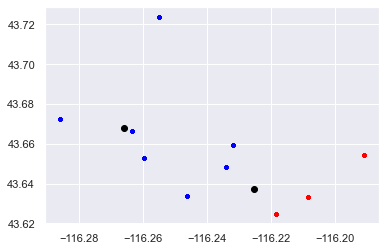

For 2 clusters we have the following graph based on weighted ML code


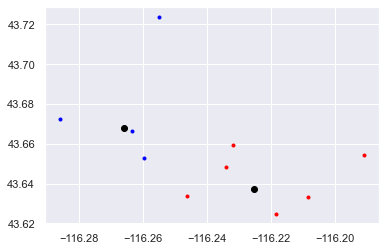

For 3 clusters we have the following graph based on custom code


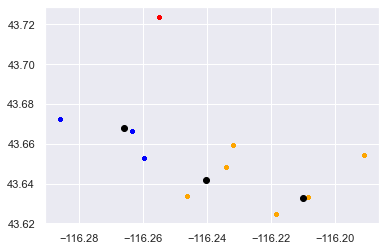

For 3 clusters we have the following graph based on weighted ML code


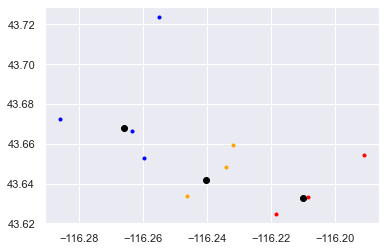

For 4 clusters we have the following graph based on custom code


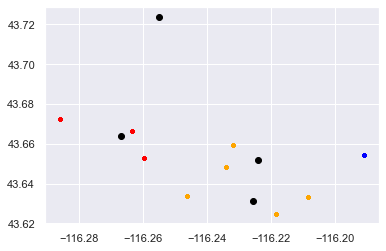

For 4 clusters we have the following graph based on weighted ML code


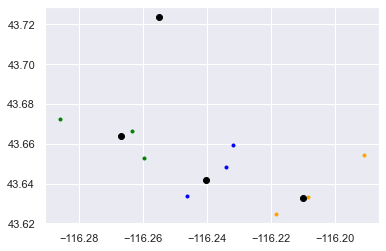

In [13]:
color = ["red", "blue", "orange", "green"]
Best_loc_lat, Best_loc_long = custom()
result, weight_list = ml_kmeans()
for K in range(2,5):
    clust=kcluster(data,distance=manhattan,k=K)
    for i in range(K):
        Lat_list = []
        Long_list = []
        location_list = clust[i]
        #get list I needed
        for j in range(len(location_list)):
            one_loc = location_list[j]
            Lat_list.append(store['Latitude'].iloc[one_loc]) 
            Long_list.append(store['Longitude'].iloc[one_loc])
        plt.scatter(Long_list, Lat_list, c = color[i],marker=".")
    l = K-2
    #append the best dots on graph
    for k in range(K):
        mylat = Best_loc_lat[l][k]
        mylong = Best_loc_long[l][k]
        plt.scatter( mylong,mylat, c = ["black"],marker="o")
        
    print("For", K, "clusters we have the following graph based on custom code")    
    plt.show()
    #ML part
    for j in range(K):
        Lat_list = []
        Long_list = []
        totallong = 0
        totallat = 0
        totalcount = 0
        for k in range(len(result[K-2])):
            if result[K-2][k] == j:
                Lat_list.append(unique[k][0])
                Long_list.append(unique[k][1])
                weight = weight_list[k]
                totalcount += weight
                totallat = totallat + unique[k][0] * weight
                totallong = totallong + unique[k][1] * weight
        mylat = totallat/totalcount
        mylong = totallong/totalcount
        plt.scatter(Long_list, Lat_list, c = color[j],marker=".")
        plt.scatter(mylong , mylat, c = ["black"],marker="o")
    print("For", K, "clusters we have the following graph based on weighted ML code")
    plt.show()

    
                

## Examples of cluster visualization in 2D

Plotting original data:
    
<img src="clusters.png">

Plotting clusters with store locations
<img src="locations.png">

Copyright &copy; 2022 Marina Barsky. All rights reserved.